# <center>Идентификация пользователей по посещенным веб-страницам

**Данная версия проекта более заточена под определение конкретного пользователя из соревнования.**

Здесь создаются признаки заточенные на отличие конкретного пользователя от остальной выборки.Более общее решение находится в той же папке проекта под названием Final_Report_General

## **Цель проекта - решение [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle**


**Описание данных**

В обучающей выборке видим следующие нецелевые признаки:
    - site1 – индекс первого посещенного сайта в сессии (расшифровка индексов приведена в файле site_dic.pkl)
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.   
В последнем случае сессии состоят менее чем из десяти сайтов, и в соответсвующих им строках имеются пропуски (NaN и NaT).
Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN / NaT), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

Целевой признак target – факт того, что сессия принадлжит Элис (то есть что именно Элис ходила по всем этим сайтам).

**Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.**

**Импортирт библиотек**

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack, vstack
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки)**

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [4]:
time_cols = ['time1', 'time2', 'time3', 'time4', 'time5',
             'time6', 'time7', 'time8', 'time9', 'time10']

In [5]:
time_cols = ['time%s' % i for i in range(1, 11)]
site_cols = ['site%s' % i for i in range(1, 11)]

In [6]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=time_cols)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=time_cols)

## Первичный анализ данных

In [7]:
train_df.head(3)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0


Посмотрим на количество уникальных сайтов в обучающей и тестовой выборках:

In [8]:
print('количество уникальных сайтов в обучающей выборке:', 
      pd.Series(train_df[site_cols].values.flatten()).nunique())
print('количество уникальных сайтов в тестовой выборке:', 
      pd.Series(test_df[site_cols].values.flatten()).nunique())
print('количество уникальных сайтов в тестовой выборке, которых нет в обучающей выборке:',
      pd.Series(test_df[site_cols].values.flatten()).nunique() - \
      len(np.unique(test_df[site_cols].values.flatten())[np.in1d(np.unique(test_df[site_cols].values.flatten()), 
                                                      np.unique(train_df[site_cols].values.flatten()))]))

количество уникальных сайтов в обучающей выборке: 41601
количество уникальных сайтов в тестовой выборке: 15857
количество уникальных сайтов в тестовой выборке, которых нет в обучающей выборке: 6770


Как видим, далеко не все сайты из тестовой выборки встречались хотя бы раз в обучающей выборке.

Загрузим словарь с URL сайтов:

In [9]:
urls = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
urls_series = pd.Series(data=list(urls.keys()), index=list(urls.values()))  #series 
urls = pd.DataFrame(data=list(urls.keys()), index=list(urls.values()), columns=['name'])  #dataframe
urls.head()

,name
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Посмотрим на частоты посещений 15 самых популярных сайтов у Alice (target=1) и у других пользователей (target=0) в рамках обучающей выборки. 

In [10]:
Alice_top15 = pd.Series(train_df.loc[train_df.target==1, site_cols].values.flatten()).value_counts().iloc[:15]
Alice_top15.index = Alice_top15.index.map(urls_series)
others_top15 = pd.Series(train_df.loc[train_df.target==0, site_cols].values.flatten()).value_counts().iloc[:15]
others_top15.index = others_top15.index.map(urls_series)

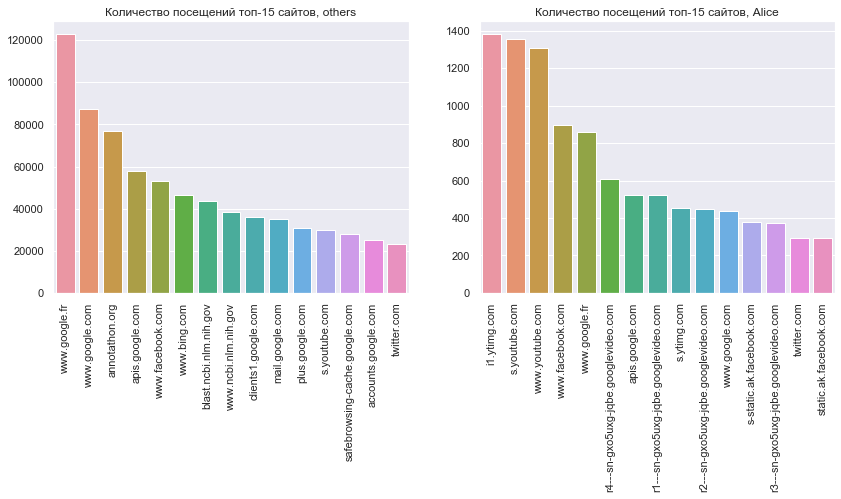

In [11]:
f, ax = plt.subplots(1,2, figsize=(14,5))

bar1 = sns.barplot(x=others_top15.index, y=others_top15.values, ax=ax[0])
ax[0].set_xticklabels(bar1.get_xticklabels(), rotation=90);
ax[0].set_title('Количество посещений топ-15 сайтов, others');

bar2 = sns.barplot(x=Alice_top15.index, y=Alice_top15.values, ax=ax[1])
ax[1].set_xticklabels(bar2.get_xticklabels(), rotation=90);
ax[1].set_title('Количество посещений топ-15 сайтов, Alice');

Видно, что Элис значительно чаще других пользователей посещает youtube, ytimg.com и некоторые другие сайты связанные с youtube.

**Тестовая выборка целиком попадает в 2014й год и полностью отделена по времени от обучающей.**

In [12]:
print('Временные границы обучающей выборки:', train_df[time_cols].min().min(), ' - ', train_df[time_cols].max().max()) 
print('Временные границы тестовой выборки:', test_df[time_cols].min().min(), ' - ', test_df[time_cols].max().max()) 

Временные границы обучающей выборки: 2013-01-12 08:05:57  -  2014-04-30 23:40:05
Временные границы тестовой выборки: 2014-05-01 17:14:03  -  2014-12-05 23:56:23


**Отсортируем данные по времени**

Это требуется для корректной разбивки на фолды через TimeSeriesSplit, что нужно для корректной кросс валидации в такой задаче.

In [13]:
train_df = train_df.sort_values(by="time1")

In [14]:
train_als = train_df.copy()
test_als = test_df.copy()
data = pd.concat([train_df, test_df], sort=False)
idx = train_df.shape[0]

**Посмотрим на распределение лет трейн/тест**

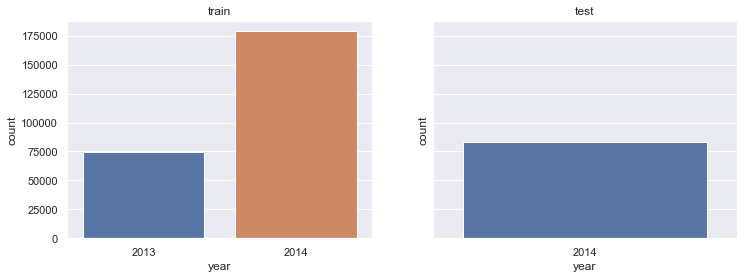

In [15]:
train_als['year'] = train_df['time1'].apply(lambda x: x.year)
test_als['year'] = test_df['time1'].apply(lambda x: x.year)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['year'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['year'], ax=ax2)
ax2.set_title('test');

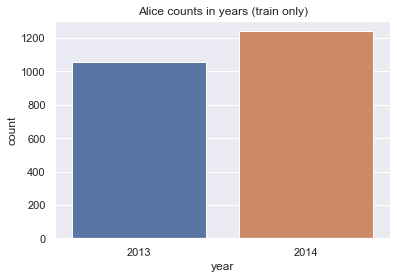

In [16]:
sns.countplot(train_als['year'][train_als['target'] == 1])
plt.title('Alice counts in years (train only)');

**Видно, что выборка состоит больше из данных за 2014й год, но Элис представлена по годам примерно равномерно.**

**Распределение месяцев трейн/тест**

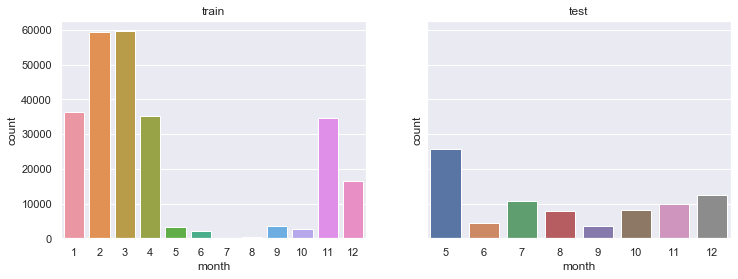

In [17]:
train_als['month'] = train_als['time1'].apply(lambda x: x.month)
test_als['month'] = test_als['time1'].apply(lambda x: x.month)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['month'], ax=ax2)
ax2.set_title('test');

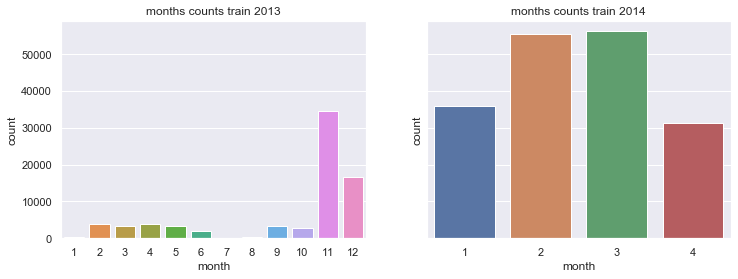

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013], ax=ax1)
ax1.set_title('months counts train 2013')
sns.countplot(train_als['month'][train_als['year'] == 2014], ax=ax2)
ax2.set_title('months counts train 2014');

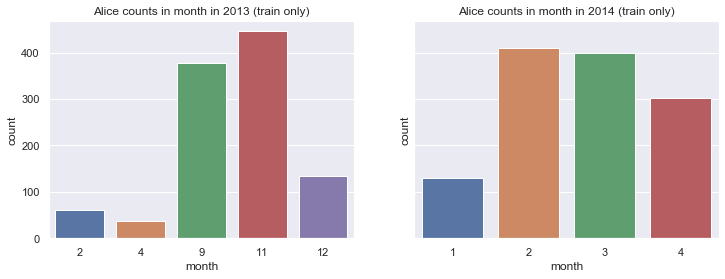

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013][train_als['target'] == 1], ax=ax1)
ax1.set_title('Alice counts in month in 2013 (train only)')

sns.countplot(train_als['month'][train_als['year'] == 2014][train_als['target'] == 1], ax=ax2)
ax2.set_title('Alice counts in month in 2014 (train only)');

Видно что в 2013м Элис не пользовалась интернетом в 1м, 3м, 10м месяце и с 5го по 8й включительно, в 2014м распределение примерно равномерное, в целом это значит что мы можем добавить в качестве фичей год и месяц, и возможно это поможет идентифицировать Элис среди остальных пользователей.


**Создадим новый признак, характеризующий пару год-месяц и посмотрим на него в обучающей выборке.**

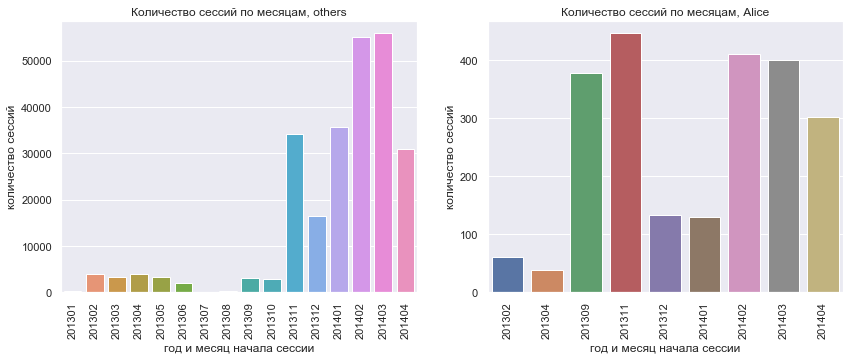

In [20]:
data['yyyymm'] = data['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
f, ax = plt.subplots(1, 2, figsize=(14,5))

countplot1 = sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'yyyymm'], ax=ax[0]); 
ax[0].set_xticklabels(countplot1.get_xticklabels(), rotation=90);
ax[0].set_title('Количество сессий по месяцам, others');
ax[0].set_xlabel('год и месяц начала сессии');
ax[0].set_ylabel('количество сессий');

countplot2 = sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'yyyymm'], ax=ax[1]);
ax[1].set_xticklabels(countplot2.get_xticklabels(), rotation=90);
ax[1].set_title('Количество сессий по месяцам, Alice');
ax[1].set_xlabel('год и месяц начала сессии');
ax[1].set_ylabel('количество сессий');

Далее можно построить аналогичные признаки и графики для часа начала сессии:

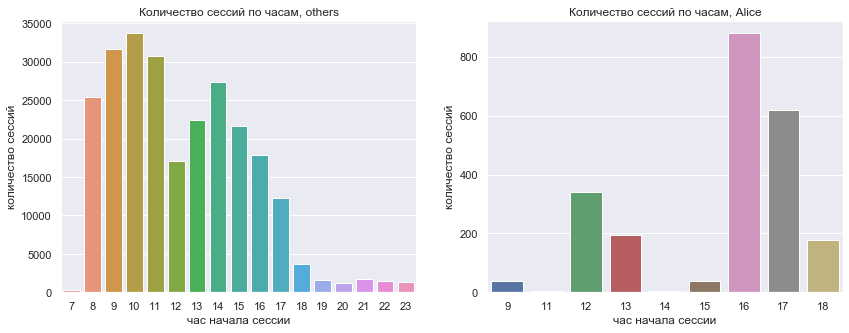

In [21]:
data['hour'] = data['time1'].apply(lambda ts: ts.hour).astype(np.int8)
_, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'hour'], ax=ax[0])
ax[0].set_title('Количество сессий по часам, others');
ax[0].set_xlabel('час начала сессии');
ax[0].set_ylabel('количество сессий');

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'hour'], ax=ax[1])
ax[1].set_title('Количество сессий по часам, Alice');
ax[1].set_xlabel('час начала сессии');
ax[1].set_ylabel('количество сессий');

Видно, что другие пользователи ни разу не начинали сессию в промежутке от полуночи до шести утра включительно и крайне редко начинали ее в семь утра. Кроме того, у других пользователей наблюдается значительный спад активности после 17 часов. А пиковая активность у них наблюдается в 10 и в 14 часов. Вероятно данные собирались в пределах учебного заведения, доступ куда в ночное время ограничен.

Alice проявляла незначительную активность в 9,11,14 и 15 часов. Пиковая активность у Alice наблюдается в 16 часов. А часы существенной активности у Alice - это 12,13,16,17,18. Кроме указанных в этом абзаце часов, Alice вообще не проявляла активности.

Теперь взглянем на продолжительность сессий (в секундах)

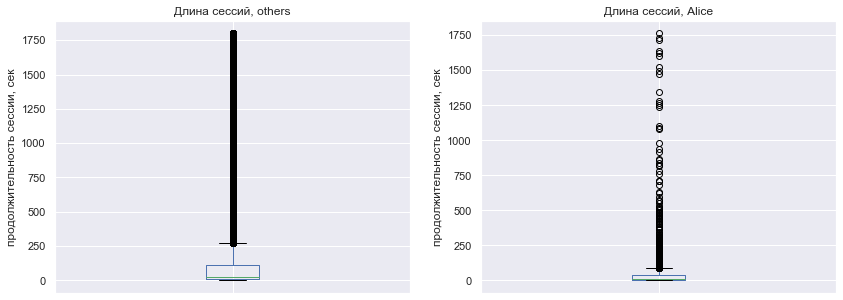

In [22]:
data['seconds'] = ((data[time_cols].max(axis=1) - data[time_cols].min(axis=1)) / np.timedelta64(1, 's'))
_, ax = plt.subplots(1, 2, figsize=(14,5))

data.iloc[:idx].loc[data.iloc[:idx].target==0, 'seconds'].to_frame(name='').boxplot(ax=ax[0]);
ax[0].set_title('Длина сессий, others');
ax[0].set_ylabel('продолжительность сессии, сек');

data.iloc[:idx].loc[data.iloc[:idx].target==1, 'seconds'].to_frame(name='').boxplot(ax=ax[1]);
ax[1].set_title('Длина сессий, Alice');
ax[1].set_ylabel('продолжительность сессии, сек');

Заметно большое количество выбросов на обоих графиках. Поэтому имеет смысл логарифмировать длину сессии:

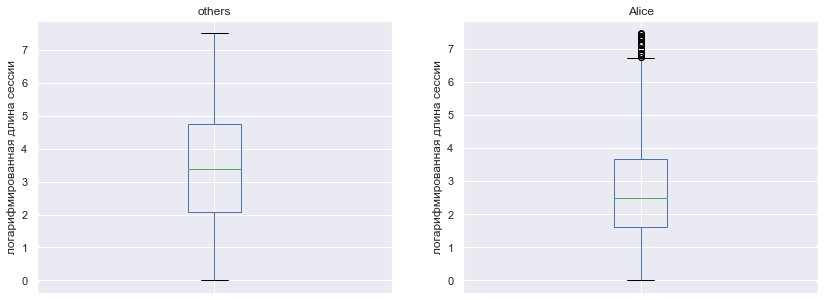

In [23]:
data['seconds'] = np.log1p(data['seconds'])
_, ax = plt.subplots(1, 2, figsize=(14,5))

data.iloc[:idx].loc[data.iloc[:idx].target==0, 'seconds'].to_frame(name='').boxplot(ax=ax[0]);
ax[0].set_title('others');
ax[0].set_ylabel('логарифмированная длина сессии');

data.iloc[:idx].loc[data.iloc[:idx].target==1, 'seconds'].to_frame(name='').boxplot(ax=ax[1]);
ax[1].set_title('Alice');
ax[1].set_ylabel('логарифмированная длина сессии');

Из графиков видно, что медианная логарифмированная длина сессии у Alice примерно равна 2.5., а у других пользователей - около 3.4. Третий квартиль (75%-ый процентиль) у Alice примерно равен 3.7, а у других пользователей - около 4.8.

In [24]:
temp = data.iloc[:idx].loc[data.iloc[:idx].target==0, 'seconds'].describe().to_frame(name='others')
temp['Alice'] = data.iloc[:idx].loc[data.iloc[:idx].target==1, 'seconds'].describe()
temp

,others,Alice
count,251264.000000,2297.000000
mean,3.433208,2.762770
std,1.798473,1.374282
min,0.000000,0.000000
25%,2.079442,1.609438
50%,3.367296,2.484907
75%,4.744932,3.663562
max,7.496097,7.475339


Выделим "длинные" сессии – сессии с продолжительностью, превосходящей третий квартиль (3.663) для Alice:

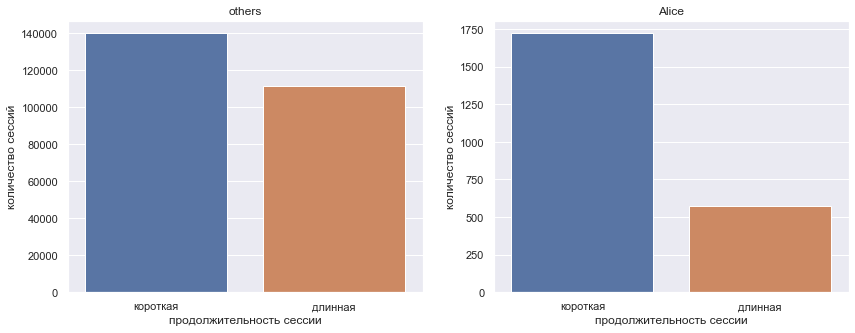

In [25]:
data['long_session'] = data['seconds'].map(lambda x: x > 3.663).astype(np.int8)
_, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'long_session'], ax=ax[0])
ax[0].set_title('others');
ax[0].set_ylabel('количество сессий');
ax[0].set_xlabel('продолжительность сессии');
ax[0].set_xticklabels(['короткая', 'длинная']);

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'long_session'], ax=ax[1])
ax[1].set_title('Alice');
ax[1].set_ylabel('количество сессий');
ax[1].set_xlabel('продолжительность сессии');
ax[1].set_xticklabels(['короткая', 'длинная']);

Посмотрим на распределение количества уникальных сайтов в сессии:

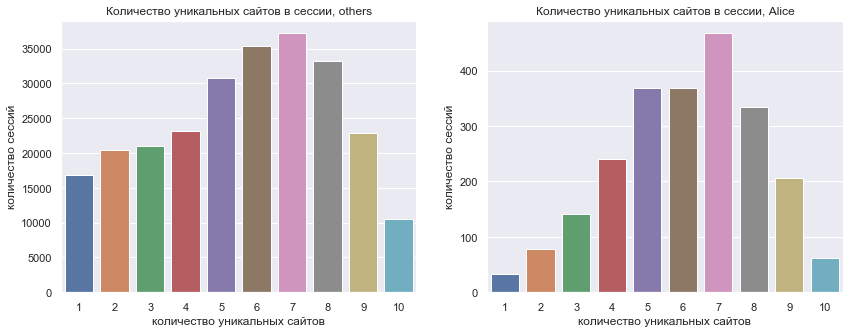

In [26]:
data['n_unique_sites'] = data[site_cols].nunique(axis = 1, dropna=True)
_, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'n_unique_sites'], ax=ax[0])
ax[0].set_title('Количество уникальных сайтов в сессии, others');
ax[0].set_xlabel('количество уникальных сайтов');
ax[0].set_ylabel('количество сессий');

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'n_unique_sites'], ax=ax[1])
ax[1].set_title('Количество уникальных сайтов в сессии, Alice');
ax[1].set_xlabel('количество уникальных сайтов');
ax[1].set_ylabel('количество сессий');

Из графиков следует, что сессии Alice реже состоят из 1,2,3 или 10 уникальных сайтов, по сравнению с другими пользователями. Поэтому вместо признака 'n_unique_sites' можно сделать следующий бинарный признак 'n_unique_sites_1-2-3-10':

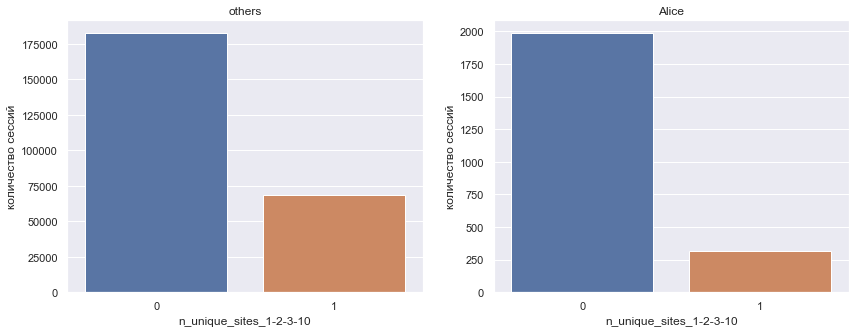

In [27]:
data['n_unique_sites_1-2-3-10'] = data['n_unique_sites'].apply(lambda x: x in [1,2,3,10]).astype(np.int8)  
data.drop('n_unique_sites', axis=1, inplace=True)
_, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'n_unique_sites_1-2-3-10'], ax=ax[0])
ax[0].set_title('others');
ax[0].set_ylabel('количество сессий');

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'n_unique_sites_1-2-3-10'], ax=ax[1])
ax[1].set_title('Alice');
ax[1].set_ylabel('количество сессий');

**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно, возможно поэтому организаторы выбрали в качестве метрики ROC AUC**

In [28]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

## **На этом с первичным анализом данных закончим, и подготовим их для обучения модели.**

Напрямую использовать id-шники сайтов (столбцы data['site1'],..., data['site10']) в качестве признаков бессмысленно. Вместо этого применим модель мешка слов (Bag of words) и затем обучить классификатор на частотах слов (т.е. на частотах сайтов). Для получения мешка слов можно использовать CountVectorizer или TfidfVectorizer (в этом соревновании последний показал лучшие результаты, поэтому мы будем использовать его):

In [29]:
#заполним пропуски в колонках site нулями
data[site_cols] = data[site_cols].fillna(0).astype(np.uint16) 

In [30]:
# представим каждую сессию в виде строки из айдишников сайтов, разделенных пробелами
data['words'] = data[site_cols].astype(np.str).apply(' '.join, axis=1)

vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 5), dtype=np.float32, 
                             tokenizer = lambda s: s.split())
words_train = vectorizer.fit_transform(data.iloc[:idx]['words'])
words_test = vectorizer.transform(data.iloc[idx:]['words'])
words = vstack([words_train, words_test])
data.drop(['words'], inplace=True, axis=1)
words

<336358x50000 sparse matrix of type '<class 'numpy.float32'>'
	with 5377647 stored elements in Compressed Sparse Row format>

# Создание признаков

Помимо уже созданных после первичного анализа пяти признаков ('yyyymm', 'hour', 'seconds', 'long_session', 'n_unique_sites_1-2-3-10') и частот сайтов (words), сформируем еще одну группу полезных признаков.

## Признаки, основанные на моменте начала сессии (time1)

Начнем со дней недели, в которые начинались сессии.

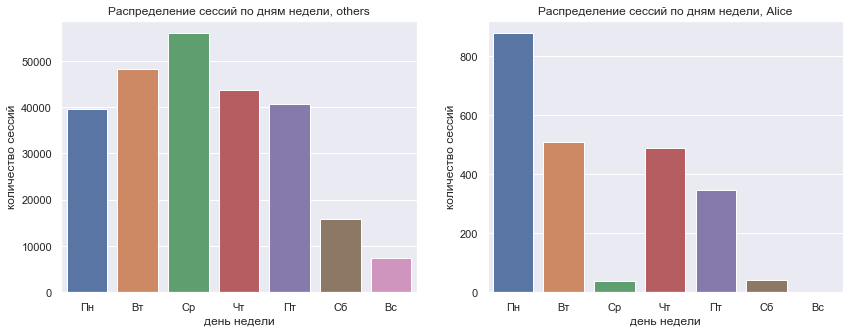

In [31]:
data['weekday'] = data['time1'].apply(lambda ts: ts.dayofweek).astype(np.int8)
f, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'weekday'], ax=ax[0])
ax[0].set_title('Распределение сессий по дням недели, others');
ax[0].set_xlabel('день недели');
ax[0].set_ylabel('количество сессий');
ax[0].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'weekday'], ax=ax[1])
ax[1].set_title('Распределение сессий по дням недели, Alice');
ax[1].set_xlabel('день недели');
ax[1].set_ylabel('количество сессий');
ax[1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

In [32]:
# Добавим бинарные признаки на те дни, когда поведение Элис отличается от большей массы других пользователей.
data['mon'] = data['time1'].apply(lambda ts: ts.dayofweek == 0).astype(np.int8) # понедельник
data['wen'] = data['time1'].apply(lambda ts: ts.dayofweek == 2).astype(np.int8) # среда
data['sat'] = data['time1'].apply(lambda ts: ts.dayofweek == 5).astype(np.int8) # суббота
data['sun'] = data['time1'].apply(lambda ts: ts.dayofweek == 6).astype(np.int8) # воскресенье

До этого мы видели что распределение активности по месяцам отличается в разные годы, посмотрим на активность по дням недели в 2013м году и в 2014м

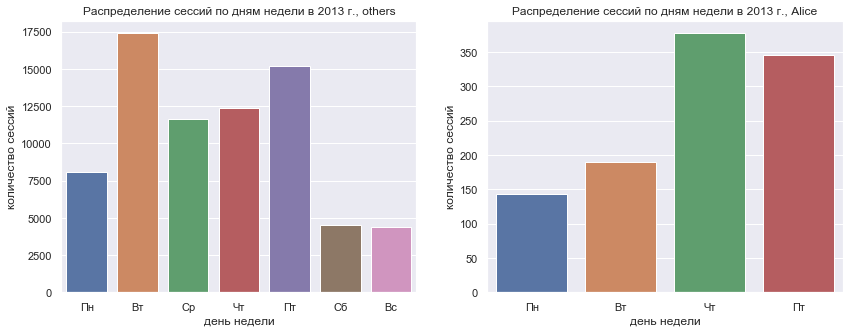

In [33]:
temp = data['time1'].apply(lambda ts: ts.year).astype(np.int16)
data['year_2013'] = (temp == 2013).astype(np.int8)
data['year_2014'] = (temp == 2014).astype(np.int8)

f, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[(data.iloc[:idx].target==0) & (data.iloc[:idx].year_2013==1), 'weekday'], ax=ax[0])
ax[0].set_title('Распределение сессий по дням недели в 2013 г., others');
ax[0].set_xlabel('день недели');
ax[0].set_ylabel('количество сессий');
ax[0].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

sns.countplot(data.iloc[:idx].loc[(data.iloc[:idx].target==1) & (data.iloc[:idx].year_2013==1), 'weekday'], ax=ax[1])
ax[1].set_title('Распределение сессий по дням недели в 2013 г., Alice');
ax[1].set_xlabel('день недели');
ax[1].set_ylabel('количество сессий');
ax[1].set_xticklabels(['Пн', 'Вт', 'Чт', 'Пт']);


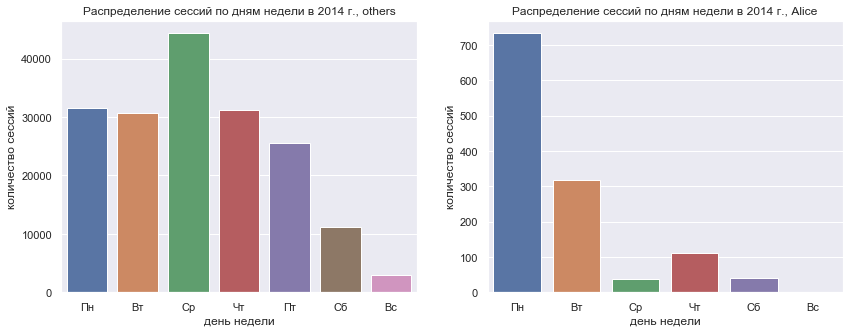

In [34]:
f, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[(data.iloc[:idx].target==0) & (data.iloc[:idx].year_2014==1), 'weekday'], ax=ax[0])
ax[0].set_title('Распределение сессий по дням недели в 2014 г., others');
ax[0].set_xlabel('день недели');
ax[0].set_ylabel('количество сессий');
ax[0].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

sns.countplot(data.iloc[:idx].loc[(data.iloc[:idx].target==1) & (data.iloc[:idx].year_2014==1), 'weekday'], ax=ax[1])
ax[1].set_title('Распределение сессий по дням недели в 2014 г., Alice');
ax[1].set_xlabel('день недели');
ax[1].set_ylabel('количество сессий');
ax[1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Сб', 'Вс']);

В 2013 году Alice проявляла активность только в понедельник, вторник, четверг и пятницу.
В 2014 году Alice проявляла активность в основном в понедельник, вторник и четверг. 
Создадим соответствующие признаки.

In [36]:
data['2013_Alice_active_days'] = ((data['year_2013'] == 1) & (data['weekday'].isin([0,1,3,4]))).astype(np.int8)
data['2014_Alice_active_days'] = ((data['year_2014'] == 1) & (data['weekday'].isin([0,1,3]))).astype(np.int8)

Ранее мы уже создали признак "час начала сессии". Теперь рассмотрим распределение начала сессий с точностью до минут:

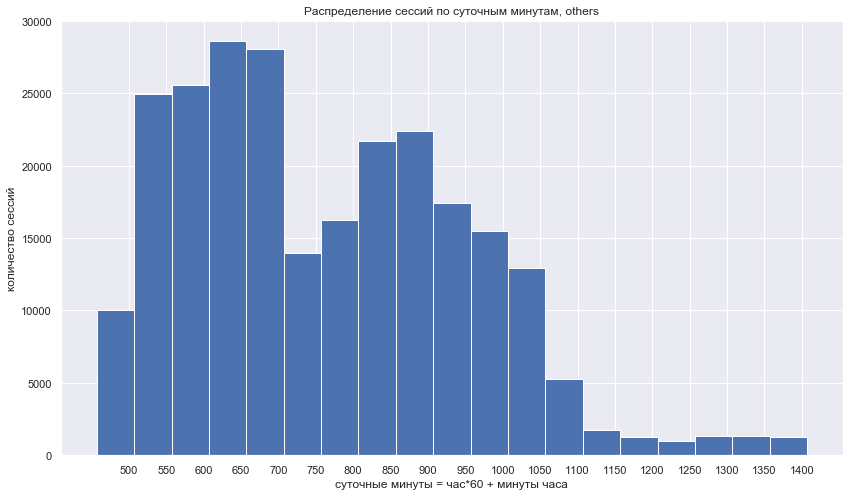

In [37]:
data['hourmins'] = data['time1'].apply(lambda ts: ts.hour*60 + ts.minute)

temp = data[:idx].loc[data[:idx].target==0, 'hourmins']
temp.hist(bins=np.arange(temp.min(), temp.max() + 2, 50), figsize=(14,8));
plt.gca().set_xticks(range(500, 1401, 50));
plt.gca().set_title('Распределение сессий по суточным минутам, others');
plt.gca().set_ylabel('количество сессий');
plt.gca().set_xlabel('суточные минуты = час*60 + минуты часа');

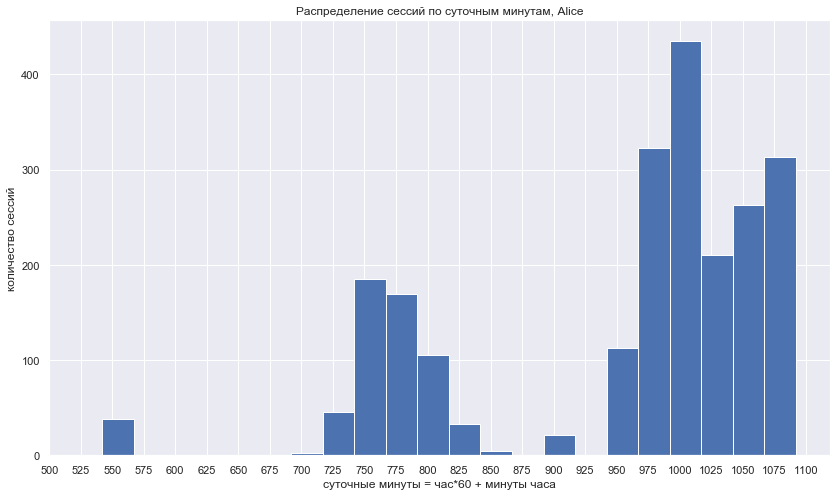

In [38]:
temp = data[:idx].loc[data[:idx].target==1, 'hourmins']
temp.hist(bins=np.arange(temp.min(), temp.max() + 2, 25), figsize=(14,8));
plt.gca().set_xticks(range(500, 1101, 25));
plt.gca().set_title('Распределение сессий по суточным минутам, Alice');
plt.gca().set_ylabel('количество сессий');
plt.gca().set_xlabel('суточные минуты = час*60 + минуты часа');

Из графика для Alice выделим периоды ее слабой активности и периоды сильной активности:

In [39]:
data['Alice_weak_1'] = ((data['hourmins'] >= 450) & (data['hourmins'] <= 720)).astype(np.int8)
data['Alice_weak_2'] = ((data['hourmins'] >= 821) & (data['hourmins'] <= 940)).astype(np.int8)
data['Alice_weak_3'] = ((data['hourmins'] >= 1101) & (data['hourmins'] <= 1450)).astype(np.int8)
data['Alice_strong'] = (((data['hourmins'] >= 721) & (data['hourmins'] <= 820)) \
                        | ((data['hourmins'] >= 941) & (data['hourmins'] <= 1100))).astype(np.int8)
data.drop('hourmins', axis=1, inplace=True)

## Признаки, основанные на адресах сайтов

In [40]:
urls['split'] = urls['name'].str.split('.')
urls['domain'] = urls['split'].map(lambda x: x[-1])

In [41]:
urls.head()

,name,split,domain
25075,www.abmecatronique.com,"[www, abmecatronique, com]",com
13997,groups.live.com,"[groups, live, com]",com
42436,majeureliguefootball.wordpress.com,"[majeureliguefootball, wordpress, com]",com
30911,cdt46.media.tourinsoft.eu,"[cdt46, media, tourinsoft, eu]",eu
8104,www.hdwallpapers.eu,"[www, hdwallpapers, eu]",eu


Посмотрим на распределение доменов сайтов у Элис и остальных пользователей

In [42]:
domains = pd.DataFrame(index=data.index)
for site in site_cols:
    domains[site] = data[site].map(urls['domain']).values
Alice_top15_doms = pd.Series(domains.iloc[:idx].loc[data.iloc[:idx].target==1].values.flatten()).value_counts().iloc[:15]
others_top15_doms = pd.Series(domains.iloc[:idx].loc[data.iloc[:idx].target==0].values.flatten()).value_counts().iloc[:15]

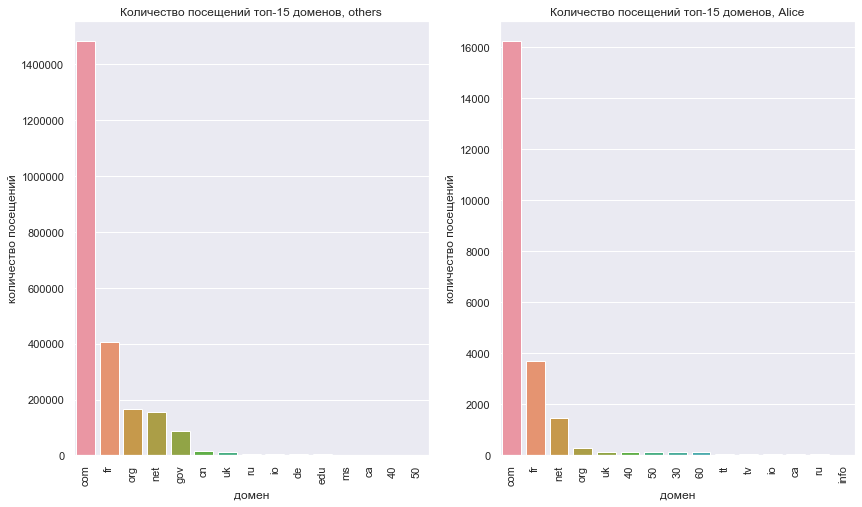

In [43]:
а, ax = plt.subplots(1,2, figsize=(14,8))

bar1 = sns.barplot(x=others_top15_doms.index, y=others_top15_doms.values, ax=ax[0])
ax[0].set_xticklabels(bar1.get_xticklabels(), rotation=90);
ax[0].set_title('Количество посещений топ-15 доменов, others');
ax[0].set_xlabel('домен');
ax[0].set_ylabel('количество посещений');

bar2 = sns.barplot(x=Alice_top15_doms.index, y=Alice_top15_doms.values, ax=ax[1])
ax[1].set_xticklabels(bar2.get_xticklabels(), rotation=90);
ax[1].set_title('Количество посещений топ-15 доменов, Alice');
ax[1].set_xlabel('домен');
ax[1].set_ylabel('количество посещений');

In [44]:
'gov' in domains.iloc[:idx].loc[data.iloc[:idx].target==1].values

False

Alice никогда не заходила на домен 'gov', который является пятым по популярности доменом среди других пользователей, создадим этот признак.

In [45]:
data['domain_gov'] = domains.apply(lambda x: 'gov' in x.values, axis=1).astype(np.int8)

Посмотрим на число сайтов в каждой сессии

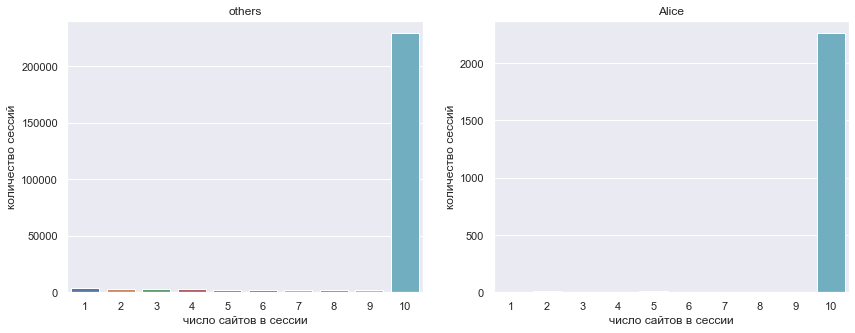

In [46]:
data['num_sites'] = data[time_cols].count(axis = 1)
f, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==0, 'num_sites'], ax=ax[0])
ax[0].set_title('others');
ax[0].set_xlabel('число сайтов в сессии');
ax[0].set_ylabel('количество сессий');

sns.countplot(data.iloc[:idx].loc[data.iloc[:idx].target==1, 'num_sites'], ax=ax[1])
ax[1].set_title('Alice');
ax[1].set_xlabel('число сайтов в сессии');
ax[1].set_ylabel('количество сессий');

Видно, что практически все сессии Alice состоят из 10 сайтов. У других пользователей неполные сессии встречаются чуть чаще. Создадим два индикатора: для сессий из 10-ти сайтов и для сессий из меньшего количества сайтов:

In [47]:
data['ten_sites'] = data['num_sites'].apply(lambda x: x == 10).astype(np.int8)
data['1-9_sites'] = data['num_sites'].apply(lambda x: x < 10).astype(np.int8)
data.drop('num_sites', axis=1, inplace=True)

Так как далее будем обучать линейную модель, то следует промасштабировать вещественные признаки. Для этого можно воспользоваться StandardScaler из sklearn:

In [48]:
features_to_scale = [
    'yyyymm',
    'seconds',
]

data[features_to_scale] = StandardScaler().fit_transform(data[features_to_scale].astype(np.float64))

**Взглянем на признаки которые у нас есть на данный момент**

In [49]:
data.drop(time_cols + site_cols + ['target'], inplace=True, axis=1)
data.to_pickle('dump.pkl')

In [50]:
data.head()

,yyyymm,hour,seconds,long_session,n_unique_sites_1-2-3-10,weekday,mon,wen,sat,sun,...,year_2014,2013_Alice_active_days,2014_Alice_active_days,Alice_weak_1,Alice_weak_2,Alice_weak_3,Alice_strong,domain_gov,ten_sites,1-9_sites
session_id,,,,,,,,,,,,,,,,,,,,,
21669,-2.079076,8,-1.920105,0,1,5,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
54843,-2.079076,8,2.264236,1,1,5,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
77292,-2.079076,8,-1.020777,0,0,5,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
114021,-2.079076,8,-1.145466,0,0,5,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
146670,-2.079076,8,-1.306218,0,0,5,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


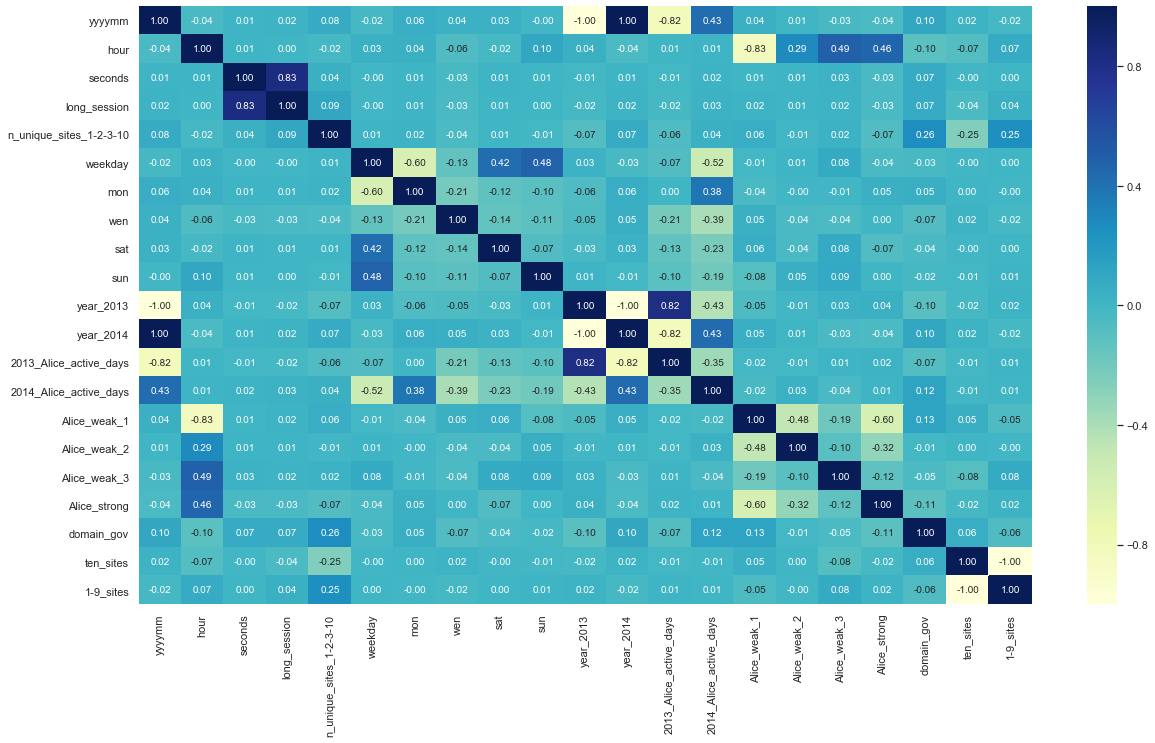

In [51]:
corr = data.corr()
plt.figure(figsize = (20, 11)) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

Видно, что у нас есть коррелированные признаки, уберем их.

In [58]:
data = pd.read_pickle('dump.pkl')

data = data.loc[:,[
    #'yyyymm', 
    #'hour', 
    'seconds', 
    'long_session', 
    'mon', 
    'wen', 
    'sat', 
    'sun', 
    #'year_2013',
    #'year_2014',
    '2013_Alice_active_days',
    '2014_Alice_active_days',
    'Alice_weak_1', 
    'Alice_weak_2', 
    'Alice_weak_3', 
    'Alice_strong', 
    'domain_gov',
    '1-9_sites', 
    'n_unique_sites_1-2-3-10',

]]

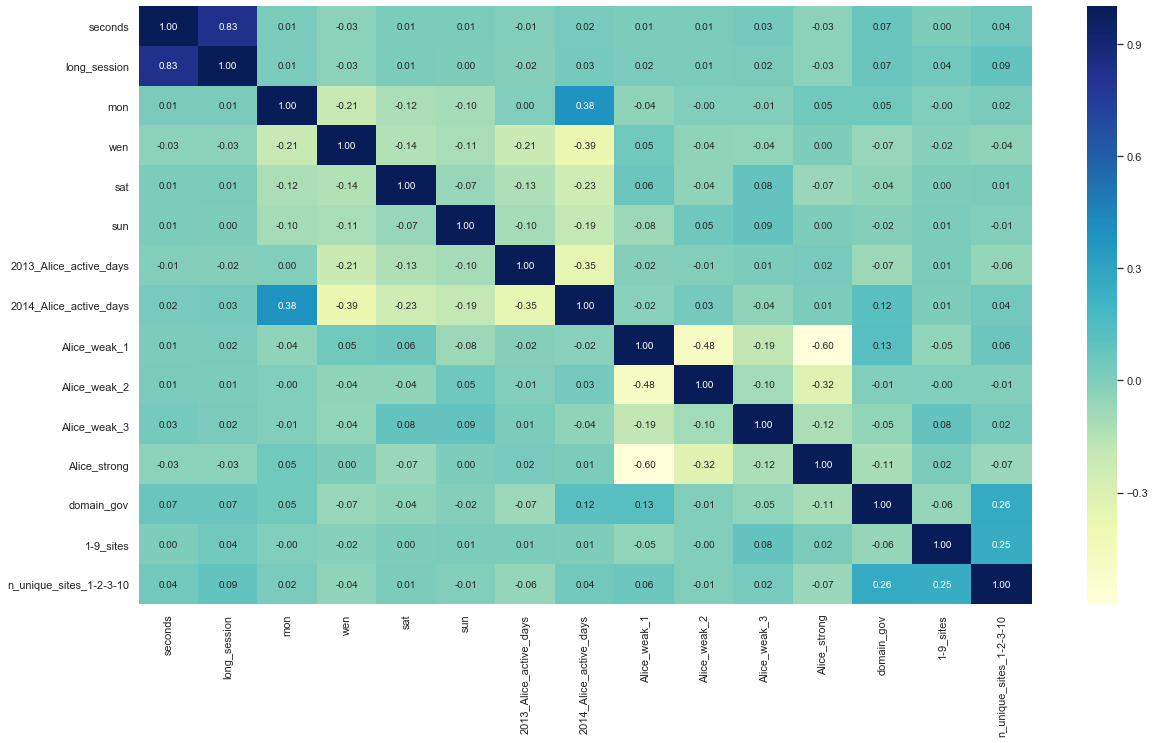

In [59]:
corr = data.corr()
plt.figure(figsize = (20, 11)) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

## Обучение модели

Подготовим обучающую и тестовую выборку к обучению, объединив результаты Tfidf с построенными признаками.

In [61]:
X_train = csr_matrix(hstack([words[:idx], data[:idx]]))
y_train = train_df.target
X_test = csr_matrix(hstack([words[idx:], data[idx:]]))

## **Обучим логистическую регрессию и её же через sgd со стандартными параметрами и проверим на паблике в качестве некоторого бейзлайна**

In [62]:
logit = LogisticRegression(C=1, random_state=42, solver='liblinear', n_jobs=-1)
sgd_logit = SGDClassifier(loss='log', random_state=42, n_jobs=-1)

In [63]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [64]:
logit_test_pred = logit.predict_proba(X_test)[:,1]

In [65]:
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [66]:
sgd_logit_test_pred = sgd_logit.predict_proba(X_test)[:,1]

In [67]:
write_to_submission_file(logit_test_pred, 'submit/submit_logit_1.csv') 
#0.94626 на паблике, ранее с помощью логистической регрессии я смог получить 0.95218 потюнив параметры.

In [68]:
write_to_submission_file(sgd_logit_test_pred, 'submit/submit_sgd_logit_1.csv') 
#0.94216 на паблике, хуже чем регрессия, что в целом понятно.
#Далее будем работать с логистической регрессией и другими моделями, данных не настолько много.

**Создадим кросс валидацию которая позволит нам валидировать без сабмитов на сайт соревнования**


In [73]:
time_split = TimeSeriesSplit(n_splits=5)

In [74]:
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

In [75]:
cv_scores

array([0.91658144, 0.92595003, 0.97385162, 0.9814665 , 0.94753764])

In [76]:
cv_scores.mean()

0.9490774436003505

Кросс валидация показывает лучший скор ближе к последним фолдам, и низкий на первых двух, это связано с механикой работы TimeSeriesSplit, на первом фолде резмер трейна совпадаем с рамером валидейта и данных еще не хватает для хорошего прогноза.

Теперь имея более менее корректную кросс валидацию попробуем потюнить параметры моделей.

Потюним параметр С используя GridSearchCV

In [77]:
logit = LogisticRegression(C=1, random_state=42, solver='liblinear', n_jobs=-1)

In [78]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [79]:
c_values

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [80]:
logit_grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [83]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9501428066178987, {'C': 4.6415888336127775})

**Построим кривую валидации**

In [84]:
train_scores_val, test_scores_val = validation_curve(logit, X_train, y_train, "C", c_values, cv = time_split, scoring="roc_auc", n_jobs=-1)

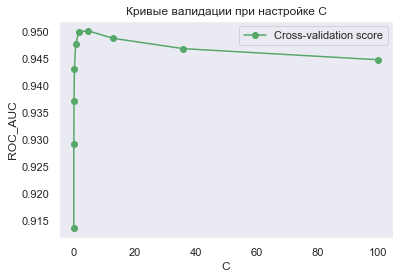

In [85]:
plt.figure()
plt.title("Кривые валидации при настройке С")
plt.xlabel("C")
plt.ylabel("ROC_AUC")
train_scores_mean = np.mean(train_scores_val, axis=1)
train_scores_std = np.std(train_scores_val, axis=1)
test_scores_mean = np.mean(test_scores_val, axis=1)
test_scores_std = np.std(test_scores_val, axis=1)
plt.grid()
plt.plot(c_values, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");

**Попробуем еще более тонкую настройку в окресностях уже найденного оптимума**

In [96]:
c_values = np.linspace(2, 5, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [97]:
c_values

array([2.        , 2.15789474, 2.31578947, 2.47368421, 2.63157895,
       2.78947368, 2.94736842, 3.10526316, 3.26315789, 3.42105263,
       3.57894737, 3.73684211, 3.89473684, 4.05263158, 4.21052632,
       4.36842105, 4.52631579, 4.68421053, 4.84210526, 5.        ])

In [98]:
logit_grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([2.        , 2.15789474, 2.31578947, 2.47368421, 2.63157895,
       2.78947368, 2.94736842, 3.10526316, 3.26315789, 3.42105263,
       3.57894737, 3.73684211, 3.89473684, 4.05263158, 4.21052632,
       4.36842105, 4.52631579, 4.68421053, 4.84210526, 

In [99]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9503636200056115, {'C': 2.7894736842105265})

**Построим кривую валидации для этого случая**

In [100]:
train_scores_val2, test_scores_val2 = validation_curve(logit, X_train, y_train, "C", c_values, cv = time_split, scoring="roc_auc", n_jobs=-1)

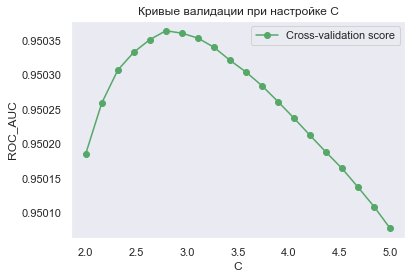

In [101]:
plt.figure()
plt.title("Кривые валидации при настройке С")
plt.xlabel("C")
plt.ylabel("ROC_AUC")
train_scores_mean = np.mean(train_scores_val2, axis=1)
train_scores_std = np.std(train_scores_val2, axis=1)
test_scores_mean = np.mean(test_scores_val2, axis=1)
test_scores_std = np.std(test_scores_val2, axis=1)
plt.grid()
plt.plot(c_values, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");

**Далее будем строить кривую обучения.**

Для выбранной нами стратегии кросс-валидации (TimeSeriesSplit) функция sklearn.model_selection.learning_curve работает некорректно (т.к. training set sizes рассчитываются ею как доли от первого фолда, это видно при установке параметра verbose=1 или при печати массива n_train). Подробнее об этом баге написано **[здесь](https://github.com/scikit-learn/scikit-learn/issues/7834)**. 
Поэтому используем аналог этой функции для работы с TimeSeriesSplit:

In [102]:
from sklearn.model_selection import cross_validate

def learn_curve(estimator, X_train, y_train, train_sizes, scoring):
    scores_train = []
    scores_val = []

    for train_size in train_sizes:
        scores = cross_validate(estimator, X_train[:train_size], y_train[:train_size], 
                                scoring=scoring, cv=time_split, return_train_score=True)
        scores_train.append(scores['train_score'].tolist())
        scores_val.append(scores['test_score'].tolist())
        
    return scores_train, scores_val

In [103]:
train_sizes = np.array(X_train.shape[0]*np.linspace(0.25, 1, 40), dtype=np.int)
scores_train, scores_val = learn_curve(logit_grid_searcher.best_estimator_, X_train, 
                                       y_train, train_sizes=train_sizes, scoring='roc_auc')

In [104]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

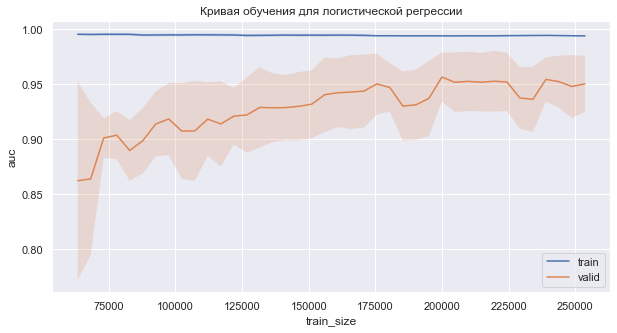

In [105]:
plt.figure(figsize=(10,5))
plt.title('Кривая обучения для логистической регрессии')
plot_learning_curve(np.array(scores_train), np.array(scores_val), train_sizes, 
                    xlabel='train_size', ylabel='auc')

**Видно что с ростом размера выборки растет и точность модели, то есть качество можно улучшить увеличив выборку.**

# **Обучим итоговую модель и загрузим результат на Kaggle**

In [107]:
logit = LogisticRegression(C=2.7894736842105265, random_state=42, solver='liblinear', n_jobs=-1)

In [108]:
logit.fit(X_train, y_train)

LogisticRegression(C=2.7894736842105265, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
logit_test_pred = logit.predict_proba(X_test)[:,1]

In [110]:
write_to_submission_file(logit_test_pred, 'submit/submit_logit_2.csv') 
#0.94452

## Обучим на тех же данных XGBoost. 

In [114]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [115]:
# Параметры для начала были взяты на примере другого участника

XGB = XGBClassifier(
    objective='binary:logistic',
    n_estimators = 230,  
    learning_rate = 0.3,
    max_depth = 3,
    colsample_bytree = 0.8,
    colsample_bylevel = 0.75,
    reg_lambda = 0.8,
    random_state=17,
    n_jobs=-1,
)

In [ ]:
# Посмотрим на кросс валидацию
cv_scores_XGB = cross_val_score(XGB, X_train, y_train, cv=time_split, scoring='roc_auc')   

In [116]:
print('cv_scores_XGB: ', np.round(cv_scores_XGB, 5))
print('mean score: ', round(cv_scores_XGB.mean(), 5))

cv_scores_XGB:  [0.88172 0.94189 0.96889 0.97703 0.95045]
mean score:  0.94399


In [117]:
# Сравним качество с линейной регрессией
print('логистическая регрессия, последние два фолда:', 
      np.round([logit_grid_searcher.cv_results_['split' + str(i) + '_test_score']
                [logit_grid_searcher.best_index_] for i in range(3,5)], 5))
print('XGBoost, последние два фолда:', np.round(cv_scores_XGB[3:], 5))

логистическая регрессия, последние два фолда: [0.98123 0.94895]
XGBoost, последние два фолда: [0.97703 0.95045]


In [118]:
# Обучим XGB
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=230, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [119]:
# Получим предсказания
XGB_test_pred = XGB.predict_proba(X_test)[:, 1]

In [120]:
write_to_submission_file(XGB_test_pred, 'submit/submit_xgb_1.csv') 
#0.95622 на паблик лидерборде, что дает позицию в 355

Результат на паблик лидерборде получился 0.95622, что дает позицию в 355 из более чем 3300 участников.
Результат линейной регрессии получился ниже, 0.94452 в данном случае.
В ходе экспериментов, максимальный результат который мне дала линейная регрессия оказался 0.95218, что ниже на 0.04 и откидывает меня примерно на 600 позиций в рейтинге.

Подберем параметры XGBoost самостоятельно с помощью gridsearchcv, это делается долго ввиду большого количества параметров и не самого мощного железа, в данном случае я запустил gridsearch перед сном.

In [137]:
n_estimators = [100,200,300]
learning_rate = [0.1,0.2,0.3]
max_depth = [2,3,4]
colsample_bytree = [0.7,0.8,0.9]
colsample_bylevel = [0.7,0.8,0.9]
reg_lambda = [0.7,0.8,0.9]




XGB_grid_searcher = GridSearchCV(estimator=XGB,
                                   param_grid={'n_estimators': n_estimators,
                                               'learning_rate':learning_rate,
                                              'max_depth':max_depth,
                                              'colsample_bytree':colsample_bytree,
                                              'colsample_bylevel':colsample_bylevel,
                                              'reg_lambda':reg_lambda
                                              },
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [138]:
XGB_grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 84.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 157.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 263.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 379.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 530.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 699.4min
[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed: 820.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.75, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=-1,
                                     nthread=None, objecti...
                                     reg_lambda=0.8, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.7, 0.8, 0.9],
                         'colsample_bytree': [0.7, 0.8, 0.9],
                      

In [140]:
XGB_grid_searcher.best_score_, XGB_grid_searcher.best_params_

(0.9466423392185072,
 {'colsample_bylevel': 0.7,
  'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 200,
  'reg_lambda': 0.7})

**Как видно, перебор одновременно нескольких гиперпараметров занимает очень много времени (по крайней мере на моем компьютере). Далее попробуем настроить более точно каждый параметр фиксируя остальные.**

In [1]:
n_estimators = [150,160,170,180,190,200,210,220,230,240,250]
learning_rate = [0.1]
max_depth = [3]
colsample_bytree = [0.7]
colsample_bylevel = [0.7]
reg_lambda = [0.7]




XGB_grid_searcher_fine_tune = GridSearchCV(estimator=XGB,
                                   param_grid={'n_estimators': n_estimators,
                                               'learning_rate':learning_rate,
                                              'max_depth':max_depth,
                                              'colsample_bytree':colsample_bytree,
                                              'colsample_bylevel':colsample_bylevel,
                                              'reg_lambda':reg_lambda
                                              },
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

NameError: name 'GridSearchCV' is not defined

In [ ]:
XGB_grid_searcher_fine_tune.fit(X_train, y_train)

In [143]:
XGB_grid_test_pred = XGB_grid_searcher.best_estimator_.predict_proba(X_test)[:, 1]

In [144]:
write_to_submission_file(XGB_grid_test_pred, 'submit/submit_xgb_grid_1.csv') 

Посмотрим на важность признаков для XGB

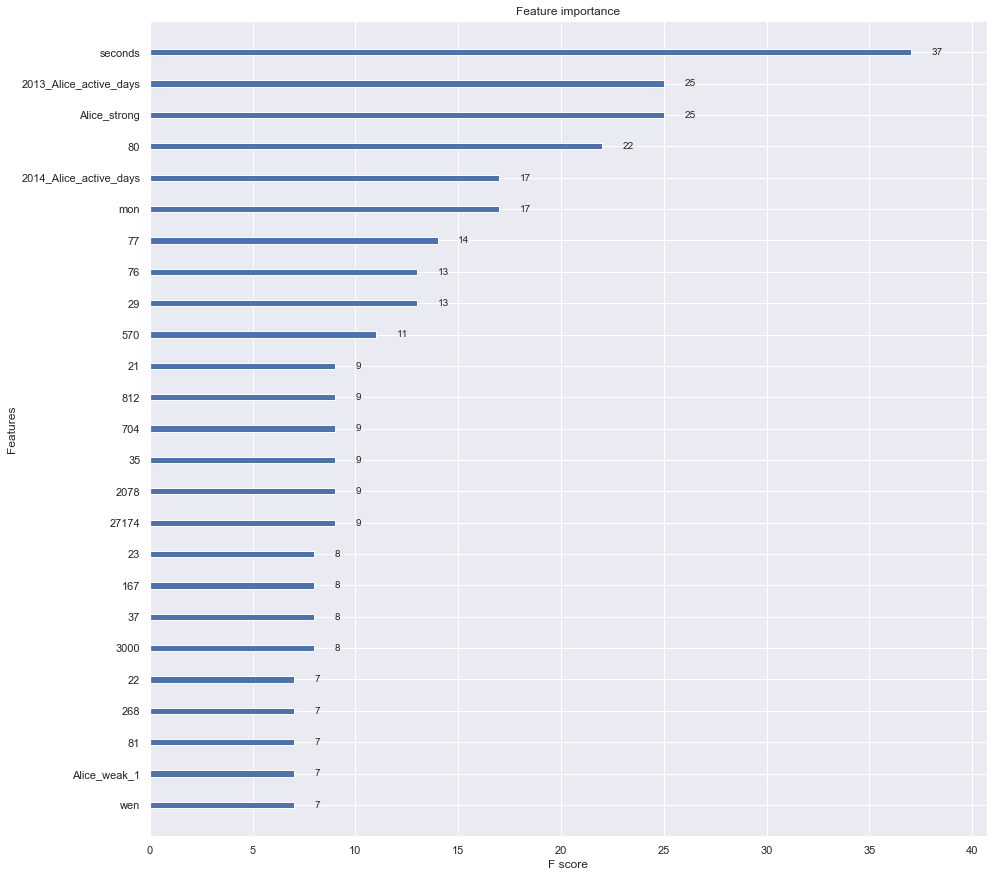

In [123]:
def plot_features(booster, figsize, cols): 
    booster.get_booster().feature_names = list(cols)
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, max_num_features=25)

sites_feats = vectorizer.get_feature_names()
plot_features(XGB, (15,15), np.concatenate((sites_feats, data.columns)));

# **Выводы**

Данная модель с некоторыми изменениями может служить для идентификации взломщиков по изменению паттерна поведения юзера.
Например пользователь зашел в почтовый ящик с нового компьютера - id браузера изменился, но по характеру поведения предсказываемому моделью - это тот же юзер. А если модель гооврит что этот юзер ведет себя не так как владелец, можно вывести ему требование пройти двухфакторную аутентификацию.
Для улучшения модели желательно увеличить объем данных и собрать его более однородно, так же можно создать дополнительные признаки, сделать one hot encoding по месяцам, посчитать время на каждом сайте в сессии и тд.
Так же можно продолжить настройку модели, попробовать разные солверы и регуляризаторы, попробовать другие методы классификации.